In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext line_profiler

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import pathlib
from functools import partial

import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble']=r"\usepackage{bm}"
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
import jax
import jax.numpy as jnp
# jax.config.update("jax_enable_x64", True)
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

import diffrax
import equinox as eqx
import optax

from haiku import PRNGSequence

In [ ]:
import exciting_environments as excenvs

import exciting_exciting_systems
from exciting_exciting_systems.models import NeuralEulerODEPendulum, NeuralODEPendulum, NeuralEulerODE, NeuralEulerODECartpole
from exciting_exciting_systems.models.model_utils import simulate_ahead_with_env
from exciting_exciting_systems.models.model_training import ModelTrainer
from exciting_exciting_systems.excitation import loss_function, Exciter

from exciting_exciting_systems.utils.density_estimation import (
    update_density_estimate_single_observation, update_density_estimate_multiple_observations, DensityEstimate, select_bandwidth
)
from exciting_exciting_systems.utils.signals import aprbs
from exciting_exciting_systems.evaluation.plotting_utils import (
    plot_sequence, append_predictions_to_sequence_plot, plot_sequence_and_prediction, plot_model_performance
)
from exciting_exciting_systems.evaluation.experiment_utils import (
    get_experiment_ids, load_experiment_results, quick_eval, evaluate_experiment_metrics, evaluate_algorithm_metrics, evaluate_metrics
)

---

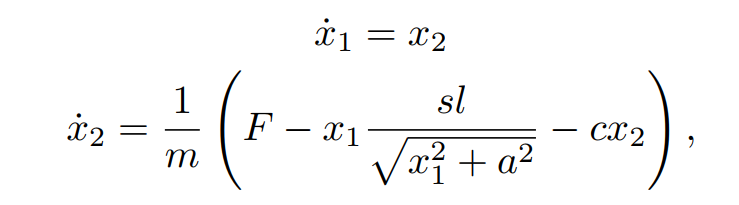

In [ ]:
from exciting_environments.mass_spring_damper.mass_spring_damper_env import MassSpringDamperCart

In [ ]:
env = MassSpringDamperCart(
    batch_size=1,
    tau=0.01,
    solver=diffrax.Euler(),
    action_constraints={"force": 400},
    static_params={
        "d": 10,
        "s": 800,
        "l": 0.17,
        "a": 0.25,
        "m": 5,
    },
    physical_constraints={
        "deflection": 2,
        "velocity": 20,
    },
)

In [ ]:
obs, state = env.reset()
obs = obs[0]

n_steps = 999

In [ ]:
data_rng = PRNGSequence(jax.random.PRNGKey(seed=0))
l = jnp.arange(21, 204+1)[..., None]
phi_l = jax.random.uniform(key=next(data_rng), shape=l.shape, minval=0, maxval=jnp.pi * 2)
# A = jax.random.normal(key=next(data_rng), shape=l.shape) * 8
# A = jax.random.normal(key=next(data_rng), shape=(1,)) * 8
N = 2048

actions = jnp.sin(2 * jnp.pi * l * 1 / N * jnp.linspace(0, 2047, 2048)[None, ...] + phi_l)
actions = jnp.sum(actions, axis=0)[..., None] / 200

actions =  actions * 8/20 / jnp.std(actions)

In [ ]:
plt.plot(actions)

In [ ]:
from jax.tree_util import tree_flatten
jnp.array(tree_flatten(env.env_properties.action_constraints)[0], dtype=jnp.float32)

In [ ]:
observations, _ = simulate_ahead_with_env(env, obs, state, actions)

print("actions.shape:", actions.shape)
print("observations.shape:", observations.shape)

print(" \n One of the trajectories:")
fig, axs = plot_sequence(
    observations=observations,
    actions=actions,
    tau=env.tau,
    obs_labels=env.obs_description,
    action_labels=env.action_description,
);
plt.show()

something is not right.. There has to be a scaling error right? The current inputs are off by a factor of 20!!

- Is the implementation and parameterization correct?
- Are the inputs correctly scaled when placed into the environment

In [ ]:
observations, _ = simulate_ahead_with_env(env, obs, state, actions)

print("actions.shape:", actions.shape)
print("observations.shape:", observations.shape)

print(" \n One of the trajectories:")
fig, axs = plot_sequence(
    observations=observations,
    actions=actions,
    tau=env.tau,
    obs_labels=env.obs_description,
    action_labels=env.action_description,
);
plt.show()

In [ ]:
from exciting_exciting_systems.algorithms import excite_with_dmpe

In [ ]:
alg_params = dict(
    bandwidth=None,
    n_prediction_steps=50,
    points_per_dim=50,
    action_lr=1e-1,
    n_opt_steps=10,
    rho_obs=1,
    rho_act=1,
    penalty_order=2,
    clip_action=True,
    n_starts=5,
    reuse_proposed_actions=True,
)
alg_params["bandwidth"] = select_bandwidth(
    delta_x=2,
    dim=env.physical_state_dim + env.action_dim,
    n_g=alg_params["points_per_dim"],
    percentage=0.3,
)

model_trainer_params = dict(
    start_learning=alg_params["n_prediction_steps"],
    training_batch_size=128,
    n_train_steps=10,
    sequence_length=alg_params["n_prediction_steps"],
    featurize=lambda x: x,
    model_lr=1e-4,
)
model_params = dict(obs_dim=env.physical_state_dim, action_dim=env.action_dim, width_size=128, depth=3, key=None)

exp_params = dict(
    seed=None,
    n_timesteps=2_500,
    model_class=NeuralEulerODEPendulum,
    env_params=None,
    alg_params=alg_params,
    model_trainer_params=model_trainer_params,
    model_params=model_params,
)

seed = 0

key = jax.random.PRNGKey(seed=seed)
data_key, model_key, loader_key, expl_key, key = jax.random.split(key, 5)
data_rng = PRNGSequence(data_key)

model_params["key"] = model_key
exp_params["model_params"] = model_params

# initial guess
proposed_actions = aprbs(alg_params["n_prediction_steps"], env.batch_size, 1, 10, next(data_rng))[0]

# run excitation algorithm
observations, actions, model, density_estimate, losses, proposed_actions = excite_with_dmpe(
    env, exp_params, proposed_actions, loader_key, expl_key, plot_every=1000
)

In [ ]:
N = 2048

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axs[0].plot(observations[:N, 0], observations[:N, 1], 'b.', markersize=2,)
axs[0].grid(True)

axs[1].plot(observations[:N, 0], actions[:N, 0], 'b.', markersize=2,)
axs[1].grid(True)
axs[2].plot(observations[:N, 1], actions[:N, 0], 'b.', markersize=2,)
axs[2].grid(True)

fig.tight_layout()
# plt.savefig("mass_spring_damper_cart_dmpe.png")

In [ ]:
from exciting_exciting_systems.models.model_utils import ModelWrapperMassSpringDamper

In [ ]:
seed = 0

alg_params = dict(
    bandwidth=None,
    n_prediction_steps=50,
    points_per_dim=50,
    action_lr=1e-1,
    n_opt_steps=10,
    rho_obs=1,
    rho_act=1,
    penalty_order=2,
    clip_action=True,
    n_starts=5,
    reuse_proposed_actions=True,
)
alg_params["bandwidth"] = select_bandwidth(
    delta_x=2,
    dim=env.physical_state_dim + env.action_dim,
    n_g=alg_params["points_per_dim"],
    percentage=0.3,
)

exp_params = dict(
    seed=None,
    n_timesteps=15_000,
    model_class=None,
    env_params=None,
    alg_params=alg_params,
    model_trainer_params=None,
    model_params=None,
    model_env_wrapper=ModelWrapperMassSpringDamper,
)

exp_params["seed"] = int(seed)

# setup PRNG
key = jax.random.PRNGKey(seed=exp_params["seed"])
data_key, _, _, expl_key, key = jax.random.split(key, 5)
data_rng = PRNGSequence(data_key)

# initial guess
proposed_actions = aprbs(exp_params["alg_params"]["n_prediction_steps"], env.batch_size, 1, 10, next(data_rng))[0]

# run excitation algorithm
observations, actions, model, density_estimate, losses, proposed_actions = excite_with_dmpe(
    env,
    exp_params,
    proposed_actions,
    None,
    expl_key,
    100
)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axs[0].plot(observations[:N, 0], observations[:N, 1], 'b.', markersize=2,)
axs[0].grid(True)

axs[1].plot(observations[:N, 0], actions[:N, 0], 'b.', markersize=2,)
axs[1].grid(True)
axs[2].plot(observations[:N, 1], actions[:N, 0], 'b.', markersize=2,)
axs[2].grid(True)

fig.tight_layout()
# plt.savefig("mass_spring_damper_cart_dmpe.png")

In [ ]:
obervations, last_state = simulate_ahead_with_env(env, obs, state, actions)

In [ ]:
last_state

In [ ]:
observations[-1] * jnp.array([2, 20])

In [ ]:
plt.plot(actions)

# debug:

In [ ]:
import jax_dataclasses as jdc

In [ ]:
@jdc.pytree_dataclass
class StaticParams:
    """Dataclass containing the static parameters of the environment."""

    c: jax.Array
    s: jax.Array
    l: jax.Array
    a: jax.Array
    m: jax.Array

In [ ]:
def msdc_step(state, F, params, tau):
    x1, x2 = tuple(state)

    d_x1 = x2.copy()
    d_x2 = (
        F.item()
        - x1 * params.s *(jnp.sqrt(x1**2 + params.a**2) - params.l) / (jnp.sqrt(x1**2 + params.a**2))
        - params.c * x2
    ) / params.m

    x1 = x1 + tau * d_x1
    x2 = x2 + tau * d_x2

    return jnp.array([x1, x2])

In [ ]:
static_params = StaticParams(
    c=10, s=800, l=0.17, a=0.25, m=5
)
tau = 0.01

In [ ]:
l = jnp.arange(21, 205)[..., None]
N = 2048

k = jnp.linspace(0, N-1, N)[None, ...]

f_s = 100
f_0 = f_s / N

In [ ]:
# generate multisine
data_rng = PRNGSequence(jax.random.PRNGKey(seed=14))

phi_l = jax.random.uniform(key=next(data_rng), shape=l.shape, minval=0, maxval=jnp.pi * 2)

actions = jnp.sin(2 * jnp.pi * l * f_0 / f_s * k + phi_l)
actions = jnp.sum(actions, axis=0)[..., None]

actions =  actions * 8 / jnp.std(actions) * 20

In [ ]:
plt.plot(actions)

In [ ]:
state = jnp.array([0, 0])

states = []

for action in actions:
    next_state = msdc_step(state, action, static_params, tau)
    state = next_state

    states.append(state)

states = jnp.stack(states)

In [ ]:
plot_sequence(states, actions, tau, ["deflection", "velocity"], ["force"])